the idea in this notebook involves no prior model, just trying to put a feedforward neural network with reduced state model instead of OpInf. More advanced version will not flatten anything and use convolutions.

In [1]:
import os
import opinf
import scipy.signal
# import cv2
os.getcwd()

'/home/ajivani/WLROM/WhiteLight'

In [2]:
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf as op

In [3]:
import time

In [4]:
from sunpy.visualization import colormaps as cm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
adjoint=True

In [7]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

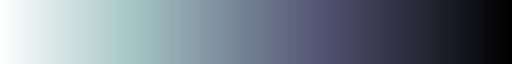

In [8]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

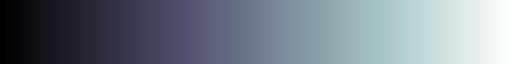

In [9]:
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

In [10]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300,
       # figsize=(9, 3)
       )
plt.rc("font",
       family="serif",
       size=10
       )
plt.rc("legend", edgecolor="none", frameon=True)
plt.rc("text", usetex=True)

### Setup training and testing data

In [11]:
m = 71

In [12]:
t_vec = (np.linspace(40, 180, m) - 40) / 60
t_vec

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333, 1.36666667, 1.4       , 1.43333333, 1.46666667,
       1.5       , 1.53333333, 1.56666667, 1.6       , 1.63333333,
       1.66666667, 1.7       , 1.73333333, 1.76666667, 1.8       ,
       1.83333333, 1.86666667, 1.9       , 1.93333333, 1.96666667,
       2.        , 2.03333333, 2.06666667, 2.1       , 2.13333333,
       2.16666667, 2.2       , 2.23333333, 2.26666667, 2.3       ,
       2.33333333])

In [13]:
dt = t_vec[1] - t_vec[0]

In [14]:
nTrainTime = np.argwhere(t_vec == (120 - 40) / 60)[0, 0]

In [15]:
nTrainTime

40

In [16]:
nTrainTimeAll = np.argwhere(np.linspace(2, 180, 90) == 40)[0,0]

In [17]:
t_train = t_vec[:(nTrainTime + 1)]
t_train[-1] * 60 + 40

120.0

In [18]:
t_test = t_vec[(nTrainTime + 1):]
t_test

array([1.36666667, 1.4       , 1.43333333, 1.46666667, 1.5       ,
       1.53333333, 1.56666667, 1.6       , 1.63333333, 1.66666667,
       1.7       , 1.73333333, 1.76666667, 1.8       , 1.83333333,
       1.86666667, 1.9       , 1.93333333, 1.96666667, 2.        ,
       2.03333333, 2.06666667, 2.1       , 2.13333333, 2.16666667,
       2.2       , 2.23333333, 2.26666667, 2.3       , 2.33333333])

In [19]:
X_orig = np.load("./CR2161_tDecay2h_Polar_Compressed.npy")

In [20]:
X = X_orig.reshape((64 * 256, 90, 278))[:, (nTrainTimeAll):, :]

In [21]:
import netCDF4 as nc
ds = nc.Dataset("./20150315_CR2161_code_stable_tDecay2h.nc")
successfulRuns = ds['runs'].successfulRuns + 30
successfulRuns

array([ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110,
       111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168,
       169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183,
       184, 185, 186, 188, 190, 191, 192, 193, 194, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

In [22]:
train_test_sims = np.load("./CR2161_AWSoM2T_CME_tDecay2h_Polar_Clusters.npz")
train_sim = train_test_sims["training_id"]
test_sim = train_test_sims["test_id"]
train_sim, test_sim

(array([  0,   1,   2,   3,   5,   6,   7,   8,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,  30,
         31,  32,  34,  35,  36,  37,  38,  39,  41,  42,  44,  45,  48,
         49,  50,  51,  52,  54,  55,  56,  57,  58,  59,  61,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  78,
         79,  82,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
         96,  98, 100, 102, 103, 104, 105, 106, 107, 108, 110, 113, 114,
        115, 116, 118, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 138, 139, 140, 142, 143, 146, 147, 148,
        149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        165, 166, 167, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 194, 196, 197,
        198, 199, 200, 201, 202, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 216, 217, 219, 220, 221, 222, 223

In [23]:
tt_sim = np.sort(np.hstack((train_sim, test_sim)))

In [24]:
X_train_ttrain = X[:, :(nTrainTime + 1), train_sim]
X_train_ttrain.shape

(16384, 41, 222)

In [25]:
X_test = X[:, :, test_sim]

In [26]:
X_train_test_ttrain = X[:, :(nTrainTime + 1), :]

In [27]:
rom_1 = op.ContinuousOpInfROM(modelform="AH")
basis_1 = op.pre.PODBasis().fit(X_train_ttrain[:, :, 0], residual_energy=1e-8)
basis_1.r

32

In [28]:
reduced_states = basis_1.encode(X_train_ttrain[:, :, 0])

In [29]:
reduced_states.shape

(32, 41)

In [30]:
reduced_states[1, :]

array([ 5.18753867,  5.4877632 ,  5.74297088,  5.93984572,  6.07472786,
        6.14135307,  6.13742178,  6.06361853,  5.92100359,  5.70977877,
        5.42965491,  5.08355595,  4.67775802,  4.21922311,  3.71461306,
        3.16796246,  2.58665005,  1.98280391,  1.36212992,  0.73077039,
        0.09351159, -0.54198027, -1.16760093, -1.77649704, -2.36307699,
       -2.92112476, -3.44261899, -3.92287053, -4.35932236, -4.74802847,
       -5.08321308, -5.36596717, -5.59438547, -5.76788039, -5.88884099,
       -5.95946237, -5.98421062, -5.96423347, -5.90416973, -5.80922226,
       -5.68420387])

### Construction of NODE Architecture

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [32]:
device

device(type='cuda', index=0)

In [33]:
t_train

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333])

In [34]:
data_size = t_train.shape[0]
batch_time = 5
batch_size = 10
print("Data size = ", data_size, " Batch time = ", batch_time, " Batch size = ", batch_size)

Data size =  41  Batch time =  5  Batch size =  10


In [35]:
t = torch.tensor(np.float32(t_train)).to(device)

In [36]:
t.dtype

torch.float32

In [37]:
true_y0 = torch.from_numpy(np.float32(reduced_states[:, 0]))
true_y0 = true_y0.reshape((1, len(true_y0))).to(device)
true_y0.shape

torch.Size([1, 32])

In [38]:
true_y0.dtype

torch.float32

In [39]:
yreduced = np.float32(reduced_states.T)
true_y = torch.from_numpy(np.expand_dims(yreduced, axis=1)).to(device)
true_y.shape

torch.Size([41, 1, 32])

In [40]:
true_y.dtype

torch.float32

Need functions for getting batch, getting true x, getting ODE func - where we run the "loss" metric compared to the true simulation.

In [41]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64),
                                          batch_size, replace=False))
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [42]:
by0, bt, by = get_batch()

In [43]:
by0.shape, bt.shape, by.shape

(torch.Size([10, 1, 32]), torch.Size([5]), torch.Size([5, 10, 1, 32]))

In [44]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [45]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(32, 50),
            nn.Tanh(),
            nn.Linear(50, 32),
        )
        
#         self.net2 = nn.Sequential(
#             nn.Linear(32, 50),
#             nn.Tanh(),
#             nn.Linear(50, 2),
#             nn.Linear(2, 50),
#             nn.Tanh(),
#             nn.Linear(50, 32),
#         )

        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
#         for m in self.net2.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

    
    def forward(self, t, y):
        return self.net1(y)
#     def forward(self, t, y):
#         return self.net1(y) + self.net2(y**2)

Check the ODE demo in a parallel notebook and replicate these functions for our case.

In [46]:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

In [47]:
niters = 500
test_freq = 10

In [48]:
func

ODEFunc(
  (net1): Sequential(
    (0): Linear(in_features=32, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=32, bias=True)
  )
)

In [49]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
#             visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()

Iter 0010 | Total Loss 0.639950
Iter 0020 | Total Loss 0.585868
Iter 0030 | Total Loss 0.579665
Iter 0040 | Total Loss 0.555417
Iter 0050 | Total Loss 0.521286
Iter 0060 | Total Loss 0.495812
Iter 0070 | Total Loss 0.483611
Iter 0080 | Total Loss 0.467063
Iter 0090 | Total Loss 0.457827
Iter 0100 | Total Loss 0.456479
Iter 0110 | Total Loss 0.450448
Iter 0120 | Total Loss 0.466032
Iter 0130 | Total Loss 0.461665
Iter 0140 | Total Loss 0.453271
Iter 0150 | Total Loss 0.449431
Iter 0160 | Total Loss 0.447148
Iter 0170 | Total Loss 0.423575
Iter 0180 | Total Loss 0.427317
Iter 0190 | Total Loss 0.419672
Iter 0200 | Total Loss 0.414142
Iter 0210 | Total Loss 0.426678
Iter 0220 | Total Loss 0.423006
Iter 0230 | Total Loss 0.417828
Iter 0240 | Total Loss 0.414060
Iter 0250 | Total Loss 0.405885
Iter 0260 | Total Loss 0.418110
Iter 0270 | Total Loss 0.411312
Iter 0280 | Total Loss 0.411817
Iter 0290 | Total Loss 0.400057
Iter 0300 | Total Loss 0.399632
Iter 0310 | Total Loss 0.405404
Iter 032

Try the same example but with prior learnt OpInf model.

### Scratch: Try resizing

(using coarse images for training), but Resize doesn't seem to be a good idea, we seem to be losing too much information, keep like this for now. If we use reduced states for training, it negates some of the need for resizing anyways.

In [ ]:
# X_orig.shape

In [ ]:
# scale_percent_ht = 70
# scale_percent_width = 40
# new_width = int(X.shape[1] * scale_percent_width / 100)
# new_height = int(X.shape[0] * scale_percent_ht / 100)
# new_dims = (new_width, new_height)
# print(new_dims)

In [ ]:
# x_sample_rs = cv2.resize(X_orig[:, :, nTrainTime, 0], new_dims, interpolation = cv2.INTER_AREA)

In [ ]:
# x_sample_rs.min(), x_sample_rs.max()

In [ ]:
# X_orig[:, :, nTrainTime, 0].min(), X[:, :, nTrainTime, 0].max()

In [ ]:
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
# axs = ax.ravel()
# im = axs[0].imshow(X_orig[:, :, nTrainTime, 0],
#               origin="lower",
#               extent=(0, 2 * np.pi, 4, 24),
#               aspect=0.05,
#               cmap=lc3_reg,
#               vmin = 0,
#               vmax = 1.5
#              )
# plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[0])

# im = axs[1].imshow(x_sample_rs,
#                   origin="lower",
#                   extent=(0, 2 * np.pi, 4, 24),
#                   aspect=0.05,
#                   cmap=lc3_reg,
#                   vmin=0,
#                   vmax=1.5
#                   )
# plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[1])